In [23]:
!pip install natsort pyedflib mne numpy 

In [24]:
!python --version

Python 3.10.12


In [25]:
import urllib.request
import numpy as np
import pyedflib
import glob
import os
import re
import numpy as np
from scipy import signal
from mne.preprocessing import ICA
from scipy.stats import zscore
import matplotlib.pyplot as plt
from natsort import natsorted

<img title="a title" alt="" src="https://www.frontiersin.org/files/Articles/516985/fncom-14-00029-HTML-r1/image_m/fncom-14-00029-g001.jpg">

<em><strong>Neocortex:</strong></em> The neocortex is covered broadly by many electrodes, given it encompasses the majority of the outer brain area. Frontal lobe functions (which include executive functions and motor control) would be monitored by electrodes placed in the frontal regions such as Fp1, Fp2, F3, F4, F7, F8. Sensory processing regions might involve more central and parietal electrodes like C3, C4, P3, and P4.

<em><strong>Amygdala</strong></em>: There are no standard EEG electrodes directly over the amygdala because it is located deep within the medial temporal lobe. However, temporal electrodes like T5 and T6 (also known as P7 and P8 in newer notation) may pick up some activity that is generated in the amygdala.

<em><strong>Hippocampus:</strong></em> Similar to the amygdala, the hippocampus is a medial temporal lobe structure, and its activity is not directly captured by surface EEG electrodes due to its deep location. The closest standard electrodes would be T5/T6 (P7/P8).

<em><strong>Basal Forebrain:</strong></em> This region does not have a specific corresponding electrode in the 10-20 system because it is a deep brain structure. But, regions such as the orbitofrontal cortex which is influenced by the basal forebrain might be monitored by the most medial prefrontal electrodes like Fp1 and Fp2.

<em><strong>Thalamus:</strong></em> Like the basal forebrain and hippocampus, the thalamus is a deep brain structure, so its activity is not directly measurable by surface EEG. No standard electrode placement corresponds to the thalamus.

<em><strong>Hypothalamus:</strong></em> The hypothalamus is also a deep brain structure not directly accessible by surface EEG electrodes.

<em><strong>Cerebellum:</strong></em> The cerebellum is located at the back of the brain, below the occipital and temporal lobes. There are no standard EEG electrodes placed over the cerebellum because standard placements are on the scalp above the cerebrum.

<em><strong>Locus Coeruleus:</strong></em> This is a small nucleus in the brainstem involved in physiological responses to stress and panic. There are no EEG electrodes that directly monitor the locus coeruleus due to its deep and central location.

<em><strong>Brain Stem:</strong></em> As with other deep structures, there are no EEG electrodes to monitor the brainstem directly.

<em><strong>Spinal Cord:</strong></em> EEG does not monitor the spinal cord.

In [26]:
dir = '/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/'
print(dir)
fpaths = dir+'/*.edf'
files = natsorted(glob.glob(fpaths))
#basefile_re_pattern = r".*0[12]\.edf$"

target_channels = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
#target_channels = []
sampling_rate = 160

epochs = []
events = []
event_markers = []

/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/


In [27]:
print(files)

['/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R01.edf', '/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R02.edf', '/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R03.edf', '/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R04.edf', '/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R05.edf', '/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R06.edf', '/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R07.edf', '/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R08.edf', '/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R09.edf', '/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/S001/S001R10.edf',

In [28]:
class Preprocess:
    def __init__(self, sfreq, target_freq=100, ica_components=64, high_pass_cutoff=8, low_pass_cutoff=16, notch_freq=60):
        self.sfreq = sfreq
        self.ica_components = ica_components
        self.high_pass_cutoff = high_pass_cutoff
        self.low_pass_cutoff = low_pass_cutoff
        self.notch_freq = notch_freq
        self.target_freq = target_freq
        #self.target_channels = target_channels
        #self.available_channels = available_channels
        self.ica = None
        
    def resample_epoch(self, epoch_data):
        #original_sfreq = self.sfreq
        #target_sfreq = self.target_freq
        num_channels, num_samples = epoch_data.shape
        target_num_samples = int(num_samples * self.target_freq / self.sfreq)
        resampled_data = signal.resample(epoch_data, target_num_samples, axis=1)
        
        return resampled_data


    def high_pass_filtering(self, eeg_epoch):
        
        nyquist_freq = 0.5 * self.sfreq
        freq_cutoff = self.high_pass_cutoff / nyquist_freq
        b, a = signal.butter(4, freq_cutoff, btype='highpass')
        filtered_epoch = signal.filtfilt(b, a, eeg_epoch, axis=1)
        
        return filtered_epoch

    def low_pass_filtering(self, eeg_epoch):
        
        nyquist_freq = 0.5 * self.sfreq
        freq_cutoff = self.low_pass_cutoff / nyquist_freq
        b, a = signal.butter(4, freq_cutoff, btype='lowpass')
        filtered_data = signal.filtfilt(b, a, eeg_epoch, axis=1)
        
        return filtered_data

    def remove_notch_noise(self, eeg_epoch):
        
        nyquist_freq = 0.5 * self.sfreq
        notch_bandwidth = 1.0  # Width of the notch filter 
        notch_freq_norm = self.notch_freq / nyquist_freq
        b, a = signal.iirnotch(notch_freq_norm, notch_bandwidth)
        filtered_data = signal.filtfilt(b, a, eeg_epoch, axis=1)
        
        return filtered_data

    def apply_ica(self, eeg_epoch):
        
        if self.ica is None:
            self.ica = ICA(n_components=self.ica_components, random_state=0)
            self.ica.fit(eeg_epoch)
        cleaned_data = self.ica.apply(eeg_epoch)
        
        return cleaned_data

    def apply_average_reference_epoch(self, epoch_data):
        
        average_reference = np.mean(epoch_data, axis=0)
        referenced_epoch_data = epoch_data - average_reference
        
        return referenced_epoch_data
    
    def normalize_epoch(self,epoch_data):
        #Min-Max Scaler 
        min_val = np.min(epoch_data, axis=1, keepdims=True)
        max_val = np.max(epoch_data, axis=1, keepdims=True)
        normalized_data = (epoch_data - min_val) / (max_val - min_val)

        return normalized_data
        

In [29]:
for file in files:
    #print(file)
    
    if re.search(r".*0[12]\.edf$", file):
        continue                                                                                        #baseline files of the subject. Evaluate for later, skip
        
    f = pyedflib.EdfReader(file)
    
    rec_channels = list(map(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x), f.getSignalLabels()))           #recorded channels, cleaned labels    
        
    if not target_channels:
        channels = {channel:i for i, channel in enumerate(rec_channels)}
    else:
        channels = {channel:i for i, channel in enumerate(rec_channels) if channel in target_channels}  #extract only 8-channel info based on Unicorn Hybrid Black EEG
    
    annotations = f.readAnnotations()                                                                   #Annotations for the MI EEG data
    event_times = annotations[0]                                                                        #event start points in the trial 
    event_durations = annotations[1]                                                                    #event duration OR time until the next start point 
    event_labels = annotations[2]                                                                       #event/action specified in https://physionet.org/content/eegmmidb/1.0.0/
    
    cut_off = 0.2
    #trial_data = np.zeros((f.signals_in_file,max(f.getNSamples())))   #(64,20000)
    trial_data = np.zeros((len(channels),max(f.getNSamples())))  #(8,20000)
    
    for i, ch_idx in enumerate(channels.values()):
        trial_data[i,:] = f.readSignal(ch_idx)
        
    for i in range(0,len(event_labels)-1,2):                                                            #sampling from start of rest-state cues, all the trials are rest-action-rest-action-rest-.... sequences
        
        start_index = int((event_times[i] + cut_off) * sampling_rate)                                   #start at rest-state event times, add cut-off to allow for neural reset
        end_index = int((event_times[i+1] + event_durations[i+1] - cut_off) * sampling_rate)            #sample as long as movement or imagined-movement cue (act) is present
    
        epoch = trial_data[:, start_index:end_index]                                                    # Assuming trial_data has shape (channels, time)
        epochs.append(epoch)                                                                         # Extarct epoch segment from the trial
        event_markers.append(event_durations[i])                                                     # Extract the rest duration interval, which is also the event marker for onset of movement/imagined movement cue
        
        
        # Extact the label relavant to the action performed as described in https://physionet.org/content/eegmmidb/1.0.0/
        
        if re.search(r".*0[37]\.edf$",file) or re.search(r".*11.edf$",file):                            #moved left hand L(T1) or right hand R(T2)
            if event_labels[i+1] == 'T1':
                events.append('L')
            else:
                events.append('R')
       
        if re.search(r".*0[48]\.edf$",file) or re.search(r".*12.edf$",file):                            #imagined left hand IL(T1) or imagined right hand IR(T2)
            if event_labels[i+1] == 'T1':
                events.append('IL')
            else:
                events.append('IR')
            
        if re.search(r".*0[59]\.edf$",file) or re.search(r".*13.edf$",file):                            #moved both fists B(T1) or both feet F(T2)
            if event_labels[i+1] == 'T1':
                events.append('B')
            else:
                events.append('F')
   
        if re.search(r".*1[04]\.edf$",file) or re.search(r".*06.edf$",file):                            #imagined both fists IB(T1) or both feet IF(T2)
            if event_labels[i+1] == 'T1':
                events.append('IB')
            else:
                events.append('IF')
                
    f.close()

In [30]:
print((events),event_labels.shape,event_markers.shape)

AttributeError: 'list' object has no attribute 'shape'

In [31]:
print(events)

['R', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'IR', 'IL', 'IL', 'IR', 'IR', 'IL', 'IR', 'IL', 'IR', 'IL', 'IL', 'IR', 'IL', 'IR', 'IL', 'F', 'B', 'F', 'B', 'F', 'B', 'B', 'F', 'F', 'B', 'F', 'B', 'B', 'F', 'B', 'IF', 'IB', 'IB', 'IF', 'IB', 'IF', 'IF', 'IB', 'IB', 'IF', 'IF', 'IB', 'IB', 'IF', 'IF', 'L', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'L', 'L', 'IL', 'IR', 'IL', 'IR', 'IL', 'IR', 'IL', 'IR', 'IR', 'IL', 'IL', 'IR', 'IR', 'IL', 'IL', 'B', 'F', 'B', 'F', 'F', 'B', 'B', 'F', 'B', 'F', 'B', 'F', 'F', 'B', 'B', 'IB', 'IF', 'IF', 'IB', 'IF', 'IB', 'IB', 'IF', 'IF', 'IB', 'IB', 'IF', 'IF', 'IB', 'IF', 'L', 'R', 'R', 'L', 'R', 'L', 'L', 'R', 'R', 'L', 'L', 'R', 'R', 'L', 'R', 'IR', 'IL', 'IR', 'IL', 'IL', 'IR', 'IR', 'IL', 'IL', 'IR', 'IR', 'IL', 'IR', 'IL', 'IR', 'B', 'F', 'B', 'F', 'F', 'B', 'F', 'B', 'B', 'F', 'B', 'F', 'F', 'B', 'F', 'IF', 'IB', 'IF', 'IB', 'IB', 'IF', 'IB', 'IF', 'IB', 'IF', 'IF', 'IB', 'IF', 'IB', 'IF']


In [32]:
min_samples_len = min(epoch.shape[1] for epoch in epochs)

#conform all the epochs to same sample-size; truncate. 

for i in range(len(epochs)):
    epochs[i] = epochs[i][:,:min_samples_len]

In [33]:
print(epochs[0].shape)

(8, 1263)


In [34]:
#preprocess all the samples
target_frequency = 100
preprocess = Preprocess(sfreq=sampling_rate, ica_components=8, target_freq=target_frequency)
for i in range(len(epochs)):
    epochs[i] = preprocess.resample_epoch(epochs[i])
    epochs[i] = preprocess.low_pass_filtering(epochs[i])
    epochs[i] = preprocess.high_pass_filtering(epochs[i])
    epochs[i] = preprocess.remove_notch_noise(epochs[i])
    epochs[i] = preprocess.apply_average_reference_epoch(epochs[i])
    epochs[i] = preprocess.normalize_epoch(epochs[i])

In [35]:
print(epochs[0])

[[0.49504488 0.45450403 0.41877379 ... 0.45322894 0.45130452 0.44306892]
 [0.54795795 0.6271701  0.69482073 ... 0.69284585 0.62572076 0.52674875]
 [0.49842058 0.72179961 0.89721061 ... 0.65561766 0.58925658 0.49627644]
 ...
 [0.51736259 0.35248151 0.21159173 ... 0.6294103  0.60594149 0.59530063]
 [0.50172332 0.52378125 0.5584209  ... 0.48762081 0.50069877 0.51335685]
 [0.47047181 0.33128576 0.21881927 ... 0.26248515 0.3565939  0.50100101]]


In [36]:
detected_change_points = []
sliding_window_size = 50
threshold = 0.05

In [37]:
def detect_change_points(eeg_epoch, sliding_window_size, threshold):
    num_channels, num_samples = eeg_epoch.shape
    epoch_change_points = []

    for channel in range(num_channels):
        channel_data = eeg_epoch[channel]
        z_scores = zscore(channel_data)

        channel_change_points = []

        for i in range(sliding_window_size, num_samples - sliding_window_size):
            mean_before = np.mean(channel_data[i - sliding_window_size:i])
            mean_after = np.mean(channel_data[i:i + sliding_window_size])
            std_before = np.std(channel_data[i - sliding_window_size:i])
            std_after = np.std(channel_data[i:i + sliding_window_size])

            if abs(mean_before - mean_after) > threshold or abs(std_before - std_after) > threshold:
                channel_change_points.append(i)

        epoch_change_points.append(channel_change_points)

    return epoch_change_points

In [38]:
for epoch in range(len(epochs)):
    epoch_change_points = detect_change_points(epochs[epoch],sliding_window_size=sliding_window_size,threshold=threshold)
    detected_change_points.append(epoch_change_points)

In [39]:
def plot_change_points(epoch, epoch_change_points, channel_labels=None, event_marker=None, event=None):
    num_channels, num_samples = epoch.shape

    fig, axs = plt.subplots(num_channels, 1, figsize=(15, 12))

    for channel in range(num_channels):
        axs[channel].plot(epoch[channel])

        channel_change_points = epoch_change_points[channel]
        axs[channel].scatter(channel_change_points, epoch[channel][channel_change_points], color='red', marker='o', label='Change Points')
        axs[channel].legend()

        if event_marker is not None:
            axs[channel].axvline(x=event_marker*target_frequency, linestyle='--', color='black', label='Event Marker')

            if event is not None:
                axs[channel].text(event_marker*target_frequency, axs[channel].get_ylim()[1], event, color='black', ha='center', va='bottom')

        if channel_labels is not None:
            axs[channel].set_ylabel(channel_labels[channel])

    plt.tight_layout()
    plt.show()


In [40]:
all_left = [(events[i],i) for i, event in enumerate(events) if events[i] == 'L']
print(all_left)

[('L', 1), ('L', 2), ('L', 5), ('L', 6), ('L', 8), ('L', 11), ('L', 12), ('L', 14), ('L', 60), ('L', 62), ('L', 64), ('L', 67), ('L', 68), ('L', 71), ('L', 73), ('L', 74), ('L', 120), ('L', 123), ('L', 125), ('L', 126), ('L', 129), ('L', 130), ('L', 133)]


In [41]:
print(detected_change_points[0][4])

[67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 275, 276, 277, 283, 284, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 491, 492, 493, 494, 495, 496, 497, 498, 499, 50

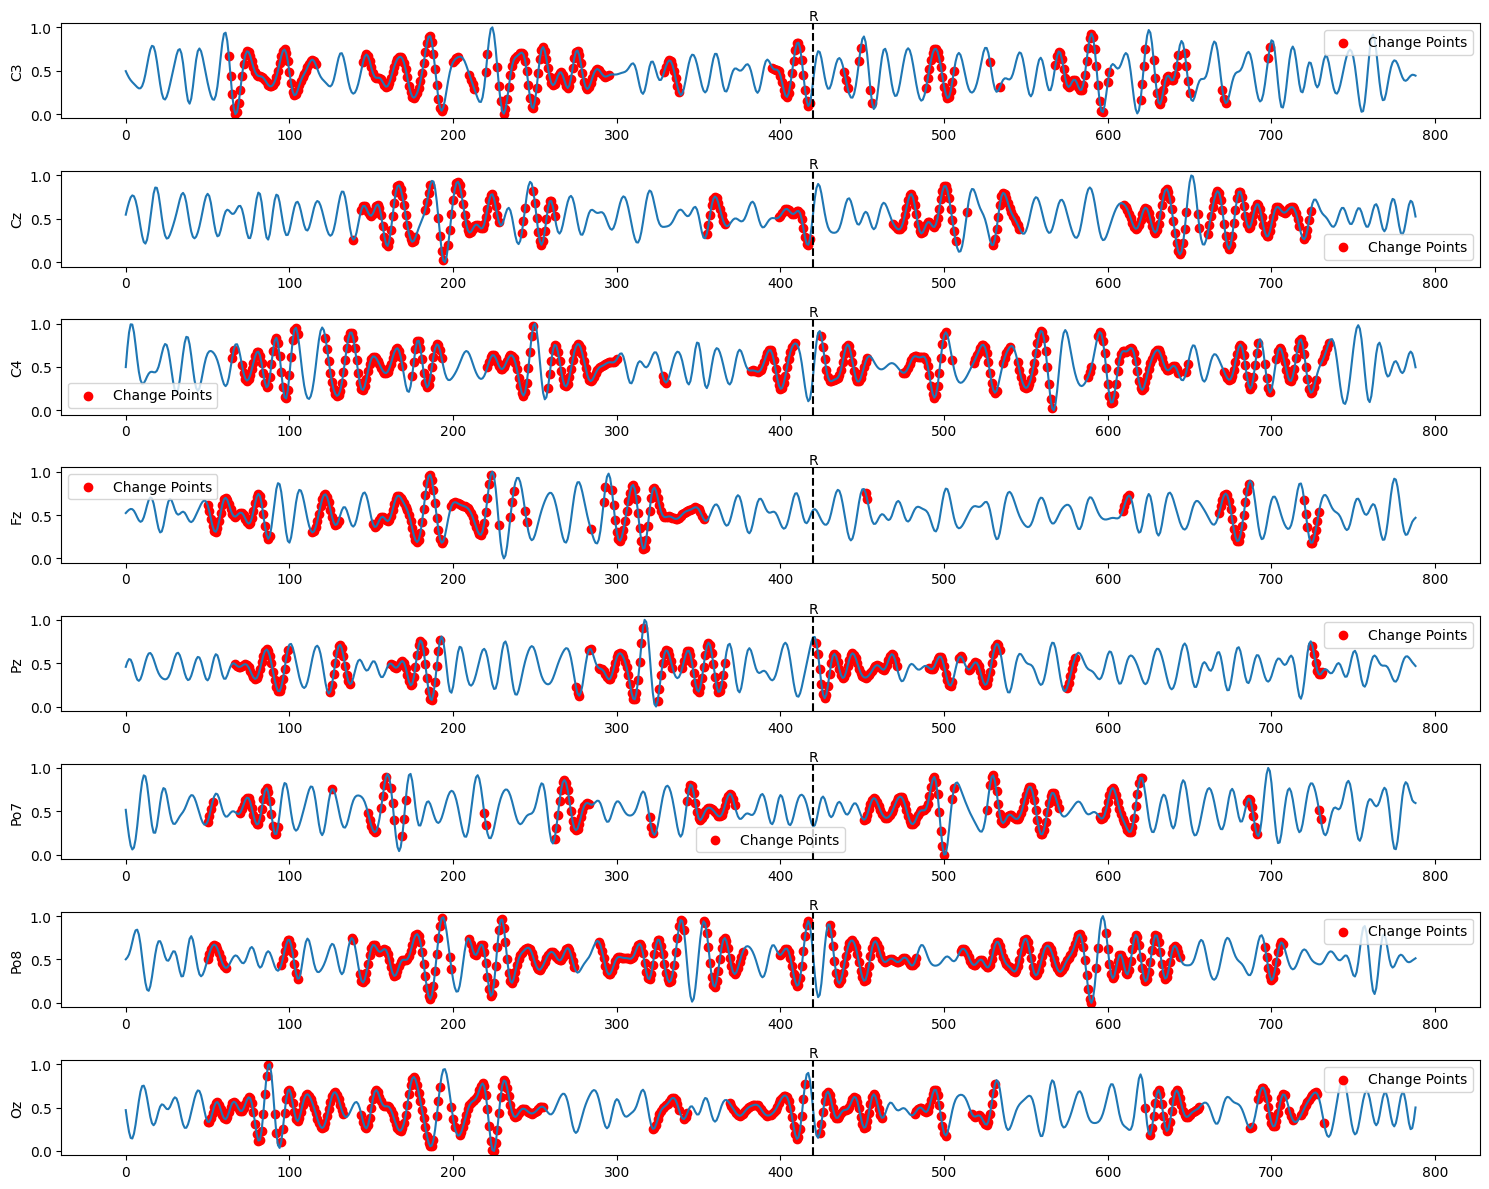

In [42]:
eval_epoch = 0
plot_change_points(epochs[eval_epoch], detected_change_points[eval_epoch], event_marker=event_markers[eval_epoch], channel_labels=list(channels.keys()), event=events[eval_epoch])

In [64]:
import numpy as np
from ruptures import Pelt
import matplotlib.pyplot as plt

num_channels, num_time_points = cp_epochs[0].shape
data = np.zeros((num_trials, num_channels, num_time_points))
print(data.shape)
print(num_trials,num_channels,num_time_points)

for i, trial in enumerate(cp_epochs):
    #print("here")
    data[i] = np.array(cp_epochs[i])

print(data)
#data = np.array(cp_epochs, dtype = object)

NameError: name 'cp_epochs' is not defined

(180, 8, 1263)
180 8 1263
[[[   4.    5.   11. ...   12.   26.   30.]
  [  40.   45.   51. ...  -10.   -1.   -4.]
  [  31.   26.   19. ...   23.   12.    2.]
  ...
  [  27.   31.   30. ...   43.   41.   55.]
  [  62.   45.   30. ...    0.  -27.    3.]
  [  46.   47.   42. ...   -9.  -16.  -10.]]

 [[   4.   -4.  -22. ...   42.  -10.  -28.]
  [   4.   -1.  -18. ...   89.   62.   10.]
  [ -27.  -10.  -20. ...   46.   23.   -2.]
  ...
  [ -20.  -29.  -42. ...  -23.  -29.   -6.]
  [ -31.  -22.  -29. ...  -13.  -21.  -38.]
  [ -25.  -25.  -23. ...    1.  -16.  -33.]]

 [[  18.   23.   15. ...   63.   78.   87.]
  [  61.   45.   22. ...   19.   43.   45.]
  [  24.   29.   18. ...   32.   44.   46.]
  ...
  [  50.   32.   35. ...   79.  118.  117.]
  [  62.   37.   36. ...   58.   65.   58.]
  [  50.   33.    5. ...   49.   93.   99.]]

 ...

 [[ -60.  -89.  -87. ...   67.   56.   26.]
  [ -24.  -68.  -80. ...   63.   48.   27.]
  [ -13.  -61.  -70. ...   81.   67.   61.]
  ...
  [ -93. -110.

In [35]:
#data = np.zeros((num_trials,num_channels,num_time_points))

# Reshape the EEG data for PELT input (shape: (num_samples, num_features))
data = np.reshape(data,(num_trials * num_channels, num_time_points))
print(data.shape)
# Perform change point detection using PELT
model = Pelt().fit(data)
result = model.predict(pen=1)


# Reshape the change point results back to per-trial format
change_points = np.reshape(result,(num_trials, -1))


# Plot the change points for each trial
for trial_idx, cp in enumerate(change_points):
    plt.plot(cp, np.ones_like(cp) * trial_idx, 'ro')
plt.xlabel('Time Points')
plt.ylabel('Trial Index')
plt.title('Change Points Detected by PELT')
plt.show()

(1440, 1263)


ValueError: cannot reshape array of size 288 into shape (180,newaxis)

In [28]:
a = np.array([[1, 2, 3, 4], [3, 4, 5, 6], [4, 5, 6, 7]])

In [29]:
print(a.shape)

(3, 4)


In [30]:
aa = np.mean(a, axis=1)

In [31]:
print(aa)

[2.5 4.5 5.5]
